### Import Necessary Libraries

In [460]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import xgboost as xgb
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, log_loss, ConfusionMatrixDisplay, plot_confusion_matrix
from matplotlib import pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
%matplotlib inline

### Read csv file

In [345]:
playstore_mobile_apps_df = pd.read_csv("Google-Playstore.csv")
pd.set_option('display.max_columns', None)

### Dataset Overview

In [205]:
playstore_mobile_apps_df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice
0,HTTrack Website Copier,com.httrack.android,Communication,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False
1,World War 2: Offline Strategy,com.skizze.wwii,Strategy,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False
2,WPSApp,com.themausoft.wpsapp,Tools,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,Business,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False
4,Loud Player Free,com.arthelion.loudplayer,Music & Audio,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False


In [206]:
playstore_mobile_apps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   App Name           1118135 non-null  object 
 1   App Id             1118136 non-null  object 
 2   Category           1118133 non-null  object 
 3   Rating             1111286 non-null  float64
 4   Rating Count       1111286 non-null  float64
 5   Installs           1117975 non-null  object 
 6   Minimum Installs   1117975 non-null  float64
 7   Maximum Installs   1118136 non-null  int64  
 8   Free               1118136 non-null  bool   
 9   Price              1118136 non-null  float64
 10  Currency           1117975 non-null  object 
 11  Size               1118136 non-null  object 
 12  Minimum Android    1116123 non-null  object 
 13  Developer Id       1118134 non-null  object 
 14  Developer Website  703770 non-null   object 
 15  Developer Email    1118114 non-n

In [207]:
playstore_mobile_apps_df.describe()

,Rating,Rating Count,Minimum Installs,Maximum Installs,Price
count,1.111286e+06,1.111286e+06,1.117975e+06,1.118136e+06,1.118136e+06
mean,2.490334e+00,5.159633e+03,3.136432e+05,5.444534e+05,2.050728e-01
std,2.053973e+00,2.724094e+05,2.043941e+07,3.031058e+07,3.541011e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.000000e+02,1.600000e+02,0.000000e+00
50%,3.600000e+00,1.100000e+01,1.000000e+03,1.719000e+03,0.000000e+00
75%,4.300000e+00,1.000000e+02,1.000000e+04,1.911600e+04,0.000000e+00
max,5.000000e+00,1.253808e+08,1.000000e+10,1.077270e+10,4.000000e+02


### Cleaning the Data

In [346]:
def fill_mode(column_name):
    playstore_mobile_apps_df[column_name].fillna(playstore_mobile_apps_df[column_name].mode()[0], inplace=True)
    return playstore_mobile_apps_df[column_name].isnull().sum()

In [347]:
def fill_median(column_name):
    playstore_mobile_apps_df[column_name].fillna(playstore_mobile_apps_df[column_name].median(), inplace=True)
    return playstore_mobile_apps_df[column_name].isnull().sum()

In [348]:
fill_mode('App Name')

0

In [349]:
fill_mode('Category')

0

In [350]:
fill_median('Rating')

0

In [351]:
fill_median('Rating Count')

0

In [352]:
fill_mode('Installs')

0

In [353]:
fill_mode('Minimum Installs')

0

In [354]:
fill_mode('Currency')

0

In [355]:
fill_mode('Minimum Android')

0

In [356]:
fill_mode('Developer Id')

0

In [357]:
fill_mode('Developer Website')

0

In [358]:
fill_mode('Developer Email')

0

In [359]:
fill_mode('Released')

0

In [360]:
fill_mode('Privacy Policy')

0

In [361]:
playstore_mobile_apps_df.isnull().values.any()

False

In [362]:
playstore_df = playstore_mobile_apps_df.copy()

### Check correlation for all numeric variables

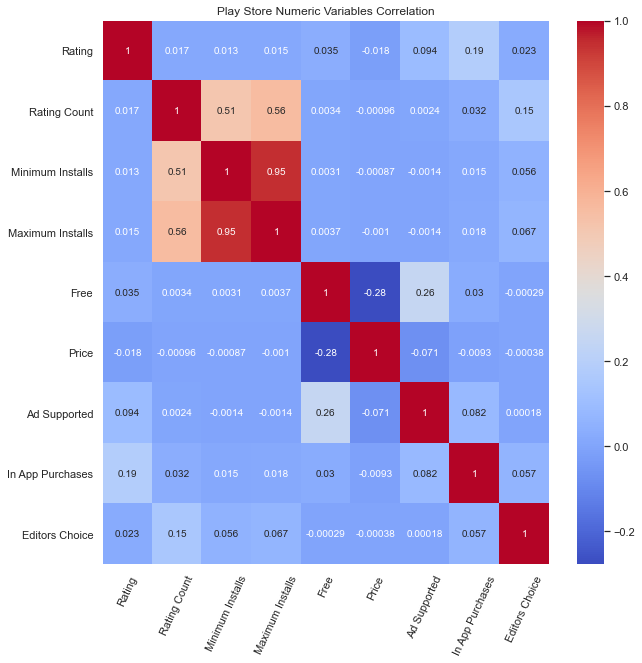

In [327]:
labels = ["Rating", "Rating Count", "Minimum Installs", "Maximum Installs", "Free", "Price", "Ad Supported", "In App Purchases", "Editors Choice"]
x_axis_labels = labels
y_axis_labels = labels

fig = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(playstore_df.corr(),cmap='coolwarm',annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set(title="Play Store Numeric Variables Correlation")
plt.xticks(rotation=65)
plt.show()

<font color='blue'>The only strong correlation factors found are between Minimum Installs and Maximum Installs</font>

### Check distribution of Rating

<AxesSubplot:xlabel='Rating', ylabel='Installs'>

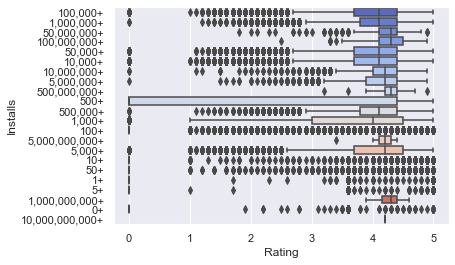

In [328]:
sns.boxplot(x="Rating", y="Installs", data=playstore_df, palette="coolwarm")

### Check distribution of Rating Count

<AxesSubplot:xlabel='Rating Count', ylabel='Installs'>

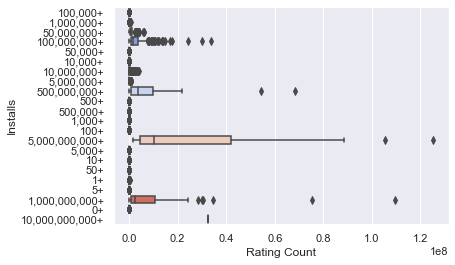

In [329]:
sns.boxplot(x="Rating Count", y="Installs", data=playstore_df, palette="coolwarm")

### Top 10 Categories in Google Playstore

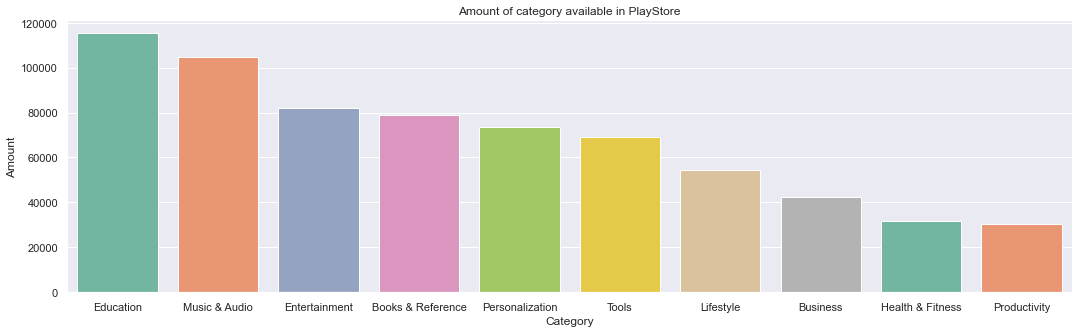

In [330]:
plt.figure(figsize=(18,5))
sns.set(style="darkgrid")
ax = sns.countplot(x="Category", data=playstore_df, palette="Set2", \
                   order=playstore_df['Category'].value_counts().index[0:10])
ax.set(xlabel='Category', ylabel='Amount', title="Amount of category available in PlayStore")
plt.show()

### Preprocessing Label (Y)

In [363]:
# Convert Installs column from string to integer
# Create new column installs_number to store the converted value
playstore_df['installs_number'] = playstore_df['Installs'].str[0:-1]
playstore_df['installs_number'] = playstore_df['installs_number'].str.replace(',', '')
playstore_df['installs_number'] = pd.to_numeric(playstore_df['installs_number'])
playstore_df[['Installs','installs_number']].head()

,Installs,installs_number
0,"100,000+",100000
1,"1,000,000+",1000000
2,"50,000,000+",50000000
3,"100,000,000+",100000000
4,"50,000+",50000


In [364]:
# sort the installs_number column from smallest to largest installs range
sorted_installs = sorted(playstore_df['installs_number'].unique())
sorted_installs

[0,
 1,
 5,
 10,
 50,
 100,
 500,
 1000,
 5000,
 10000,
 50000,
 100000,
 500000,
 1000000,
 5000000,
 10000000,
 50000000,
 100000000,
 500000000,
 1000000000,
 5000000000,
 10000000000]

In [365]:
# put the sorted list in dictionary key-value format
sorted_installs_list = {}
for idx, val in enumerate(sorted_installs):
    sorted_installs_list[val] = idx
print(sorted_installs_list)

{0: 0, 1: 1, 5: 2, 10: 3, 50: 4, 100: 5, 500: 6, 1000: 7, 5000: 8, 10000: 9, 50000: 10, 100000: 11, 500000: 12, 1000000: 13, 5000000: 14, 10000000: 15, 50000000: 16, 100000000: 17, 500000000: 18, 1000000000: 19, 5000000000: 20, 10000000000: 21}


In [366]:
# create new column to store the installs key which range from 1-21
playstore_df['installs_key'] = playstore_df['installs_number'].map(sorted_installs_list)
playstore_df['installs_key']

0          11
1          13
2          16
3          17
4          10
           ..
1118131     3
1118132     5
1118133     5
1118134     6
1118135     9
Name: installs_key, Length: 1118136, dtype: int64

### Installs key distribution (sorted installs range)

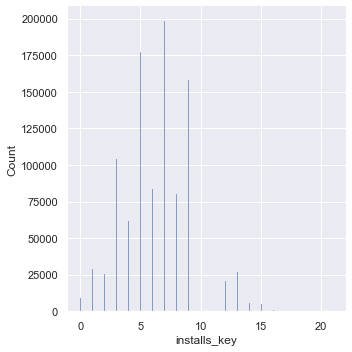

In [367]:
sns.displot(playstore_df['installs_key'])

<font color="green"> There are too many distribution keys to fit into machine learning model so classify installs base on quantiles </font>

In [368]:
installs_quantile_list = [0, .25, .5, .75, 1.]
installs_quantiles = playstore_df['installs_key'].quantile(installs_quantile_list)
installs_quantiles

0.00     0.0
0.25     5.0
0.50     7.0
0.75     9.0
1.00    21.0
Name: installs_key, dtype: float64

<font color="green"> Histogram to view the quantiles for binning </font>

Text(0, 0.5, 'Frequency')

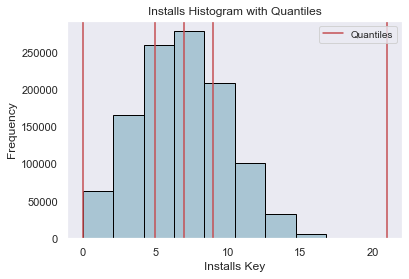

In [369]:
ig, ax = plt.subplots()
playstore_df['installs_key'].hist(color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in installs_quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Installs Histogram with Quantiles', fontsize=12)
ax.set_xlabel('Installs Key', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [370]:
# store the new value for binning in installs_label column
installs_quantile_labels = [0, 1, 2, 3]

playstore_df['installs_label'] = pd.qcut(playstore_df['installs_key'], 
                                         q=installs_quantile_list, labels=installs_quantile_labels)

playstore_df['installs_label'] = playstore_df['installs_label'].astype(int)
playstore_df['installs_label']

0          3
1          3
2          3
3          3
4          3
          ..
1118131    0
1118132    0
1118133    0
1118134    1
1118135    2
Name: installs_label, Length: 1118136, dtype: int64

In [439]:
playstore_df_copy = playstore_df.copy()

In [441]:
playstore_df_copy['category'] = playstore_mobile_apps_df['Category']
playstore_df_copy.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend,last_updated_datetime,released_last_update_difference,category
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0,2017-05-20,1.675862,Communication
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0,2020-11-26,0.964138,Strategy
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0,2020-10-21,2.106207,Tools
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0,2020-11-23,4.271724,Business
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1,2020-11-22,1.873103,Music & Audio


In [454]:
top_categories = playstore_df_copy.groupby('category')['installs_number'].agg('max').nlargest(10).reset_index()
top_categories.sort_values(by='installs_number', ascending=False, inplace=True)
top_categories

,category,installs_number
0,Tools,10000000000
1,Communication,5000000000
2,Music & Audio,5000000000
3,Productivity,5000000000
4,Social,5000000000
5,Travel & Local,5000000000
6,Video Players & Editors,5000000000
7,Arcade,1000000000
8,Auto & Vehicles,1000000000
9,Books & Reference,1000000000


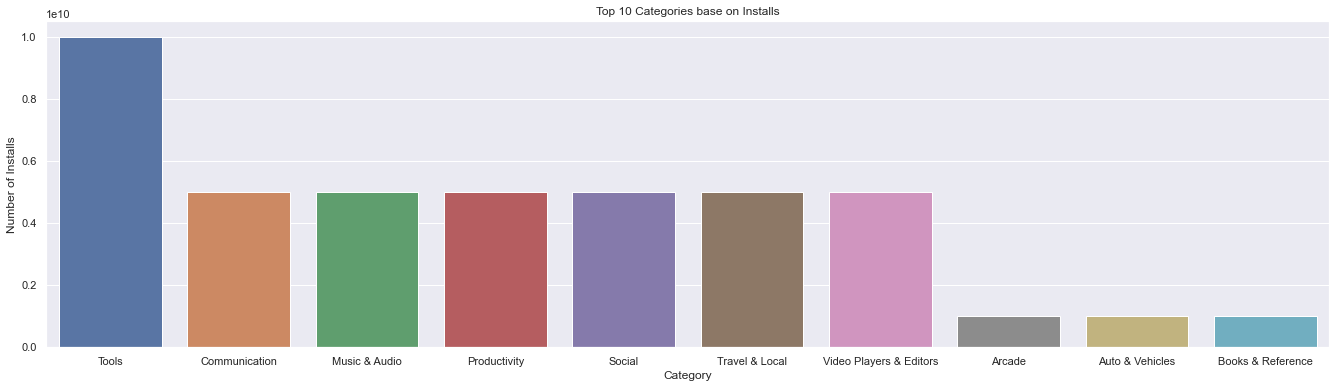

In [456]:
plt.figure(figsize=(23,6))
ax = sns.barplot(x="category", y="installs_number", data=top_categories)
ax.set(xlabel='Category', ylabel='Number of Installs', title="Top 10 Categories base on Installs")
plt.show()

### Preprocessing Data and Feature Engineering Process for the Raw Features (X)

<font color="green"> Encode the category column using binary encoding </font>

In [371]:
#Create object for binary encoding
encoder= ce.BinaryEncoder(cols=['Category'],return_df=True)

#Fit and Transform Data 
playstore_df=encoder.fit_transform(playstore_df) 
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3


<font color="green"> Encode the rating column using custom quantile binning </font>

In [372]:
# the 0.25 quantile is skipped because the value of .25 quantile is same as 0 quantile
rating_quantile_list = [0, .5, .75, 1.]
rating_quantiles = playstore_df['Rating'].quantile(rating_quantile_list)
rating_quantiles

0.00    0.0
0.50    3.6
0.75    4.3
1.00    5.0
Name: Rating, dtype: float64

Text(0, 0.5, 'Frequency')

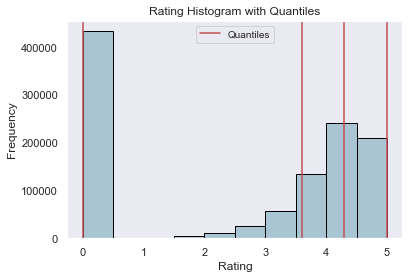

In [373]:
ig, ax = plt.subplots()
playstore_df['Rating'].hist(color='#A9C5D3', 
                             edgecolor='black', grid=False)
for quantile in rating_quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Rating Histogram with Quantiles', 
             fontsize=12)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [374]:
rating_quantile_labels = [0, 1, 2]
playstore_df['rating_code'] = pd.qcut(playstore_df.Rating,
                                          q=rating_quantile_list, 
                                          labels=rating_quantile_labels)

playstore_df['rating_code'] = playstore_df['rating_code'].astype(int)
playstore_df['rating_code']

0          0
1          1
2          1
3          1
4          1
          ..
1118131    0
1118132    0
1118133    0
1118134    0
1118135    2
Name: rating_code, Length: 1118136, dtype: int64

<font color="green"> Encode the rating count column using custom quantile binning </font>

In [375]:
# the quantile is split into 2: below 0.75 quantile and above 0.75 quantile
# Previously shown on the rating count boxplot that distribution has many outliers and many apps with 0 rating count
rating_count_quantile_list = [0,.75, 1.]
rating_count_quantiles = playstore_df['Rating Count'].quantile(rating_count_quantile_list)
rating_count_quantiles

0.00            0.0
0.75           99.0
1.00    125380770.0
Name: Rating Count, dtype: float64

In [376]:
rating_count_quantile_labels = [0, 1]
playstore_df['rating_count_code'] = pd.qcut(playstore_df['Rating Count'],
                                          q=rating_count_quantile_list, 
                                          labels=rating_count_quantile_labels)

playstore_df['rating_count_code'] = playstore_df['rating_count_code'].astype(int)
playstore_df['rating_count_code']

0          1
1          1
2          1
3          1
4          1
          ..
1118131    0
1118132    0
1118133    0
1118134    0
1118135    0
Name: rating_count_code, Length: 1118136, dtype: int64

<font color="green"> Method for dummy encoding </font>

In [377]:
def dummy_encode(column_name):
    global playstore_df
    dummy = pd.get_dummies(playstore_df[column_name], prefix=column_name, drop_first= True)
    playstore_df = pd.concat([playstore_df, dummy], axis=1)
    return playstore_df.head()

<font color="green"> Dummy encoding for Free Column </font>

In [378]:
dummy_encode('Free')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1


<font color="green"> Dummy encoding for Ad Supported Column </font>

In [379]:
dummy_encode('Ad Supported')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0


<font color="green"> Dummy encoding for In App Purchases Column </font>

In [380]:
dummy_encode('In App Purchases')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0


<font color="green"> Dummy encoding for In Editors Choice Column </font>

In [381]:
dummy_encode('Editors Choice')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0


<font color="green"> Custom ordinal encoding for Minimum Android Column </font>

In [382]:
# split up the strings for the values in Minimum Android column
version = playstore_df['Minimum Android'].str.split(" ", n = 0, expand = True)
version

,0,1,2
0,2.3,and,up
1,5.1,and,up
2,4.1,and,up
3,4.4,and,up
4,5.0,and,up
...,...,...,...
1118131,Varies,with,device
1118132,4.1,and,up
1118133,5.0,and,up
1118134,4.1,and,up


In [383]:
# find the mode for the minimum android column
version[0].mode()

0    4.1
dtype: object

In [384]:
# replace the string "varies" with the mode
version[0]= version[0].replace('Varies', '4.1')
version[0]

0          2.3
1          5.1
2          4.1
3          4.4
4          5.0
          ... 
1118131    4.1
1118132    4.1
1118133    5.0
1118134    4.1
1118135    4.1
Name: 0, Length: 1118136, dtype: object

In [385]:
# check all the unique values for minimum android
version[0].unique()

array(['2.3', '5.1', '4.1', '4.4', '5.0', '6.0', '4.2', '4.0', '8.0',
       '7.0', '3.2', '1.5', '4.3', '4.0.3', '2.2', '2.1', '7.1', '4.4W',
       '2.3.3', '3.0', '1.6', '2.0', '2.0.1', '3.1', '1.0', '1.1'],
      dtype=object)

In [386]:
# replace values 4.0.3, 4.4W, 2.3.3 and 2.0.1 before converting to float
version[0]= version[0].replace('4.0.3', '4.0')
version[0]= version[0].replace('4.4W', '4.4')
version[0]= version[0].replace('2.3.3', '2.3')
version[0]= version[0].replace('2.0.1', '2.0')
version[0] = version[0].astype(float)

In [387]:
# create new column version_code and copy the minimum android values to that column
playstore_df['version_code'] = version[0]
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0


<font color="green"> Custom ordinal encoding for content rating </font>

In [388]:
content_rating_dict = {
    'Everyone' : 0,
    'Everyone 10+' : 0,
    'Teen' : 1,
    'Mature 17+' : 2,
    'Adults only 18+' : 2,
    'Unrated' : 0
}

In [389]:
playstore_df['content_rating_code'] = playstore_df['Content Rating'].map(content_rating_dict)
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0


<font color="green"> Encode the developer id using quantile binning </font>

In [390]:
# create new column to store the frequency of the developer id for each apps
playstore_df['developer_id_count']= playstore_df['Developer Id'].map(playstore_df['Developer Id'].value_counts())
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,1
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,4
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,3
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,175
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,2


<font color="green"> Use quantile binning to segregate them into 4 different groups for easier encoding </font>

In [391]:
developer_count_quantile_list = [0, .25, .5, .75, 1.]
developer_count_quantiles = playstore_df['developer_id_count'].quantile(developer_count_quantile_list)
developer_count_quantiles

0.00      1.0
0.25      7.0
0.50     20.0
0.75     54.0
1.00    540.0
Name: developer_id_count, dtype: float64

In [392]:
developer_count_labels = [0, 1, 2, 3]

playstore_df['developer_id_count'] = pd.qcut(playstore_df['developer_id_count'], 
                                                 q=developer_count_quantile_list, labels=developer_count_labels)

playstore_df['developer_id_count'] = playstore_df['developer_id_count'].astype(int)
playstore_df['developer_id_count']

0          0
1          0
2          0
3          3
4          0
          ..
1118131    1
1118132    1
1118133    1
1118134    1
1118135    1
Name: developer_id_count, Length: 1118136, dtype: int64

<font color="green"> Encode Released Year Column </font>

In [393]:
# Convert released year to datetime format and store in released_datetime column
playstore_df['released_datetime'] = pd.to_datetime(playstore_df['Released'])
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24


In [394]:
# derive released year column from released datetime column
playstore_df['released_year'] = playstore_df['released_datetime'].dt.year
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,2013
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,2018
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,2016
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,2011
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,2016


In [395]:
playstore_df['released_year'].unique()

array([2013, 2018, 2016, 2011, 2019, 2020, 2015, 2012, 2014, 2010, 2017])

In [396]:
# Since the unique values for the released_year are in the 21st century, can simply delete the first two characters
playstore_df['released_year'] = playstore_df['released_year'] % 100
playstore_df['released_year'].head()

0    13
1    18
2    16
3    11
4    16
Name: released_year, dtype: int64

<font color="green"> Robust Scaler Method </font>

In [397]:
def apply_robust_scaler(column_name):
    global playstore_df
    rs = preprocessing.RobustScaler()
    playstore_df[column_name] = rs.fit_transform(playstore_df[[column_name]])
    return playstore_df.head()

In [398]:
# apply robust scaling to released_year column
apply_robust_scaler('released_year')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667


In [399]:
# derive released month column from released datetime column
playstore_df['released_month'] = playstore_df['released_datetime'].dt.month
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,8
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,7
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,3
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,12
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,9


In [400]:
# apply robust scaling to released_month column
apply_robust_scaler('released_month')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333


In [401]:
# derive released date column from released datetime column
playstore_df['released_date'] = playstore_df['released_datetime'].dt.day
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,12
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,19
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,7
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,22
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,24


In [402]:
# apply robust scaling to released_date column
apply_robust_scaler('released_date')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333


In [403]:
# derive if released date is on weekend from released datetime column
day_names = playstore_df['released_datetime'].dt.day_name()
is_weekend = day_names.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
playstore_df['released_weekend'] = is_weekend
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1


In [404]:
# derive last updated datetime column from last updated column
playstore_df['last_updated_datetime'] = pd.to_datetime(playstore_df['Last Updated'])
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend,last_updated_datetime
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0,2017-05-20
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0,2020-11-26
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0,2020-10-21
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0,2020-11-23
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1,2020-11-22


In [405]:
# derive update_release_difference column from both released datetime and last updated columns
playstore_df['released_last_update_difference'] = playstore_df['last_updated_datetime'] - playstore_df['released_datetime']
playstore_df['released_last_update_difference'] = playstore_df['released_last_update_difference'].abs()
playstore_df['released_last_update_difference'] = playstore_df['released_last_update_difference'].astype('timedelta64[D]').astype('int')
playstore_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend,last_updated_datetime,released_last_update_difference
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0,2017-05-20,1377
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0,2020-11-26,861
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0,2020-10-21,1689
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0,2020-11-23,3259
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1,2020-11-22,1520


In [406]:
# apply robust scaling to released_last_update_difference column
apply_robust_scaler('released_last_update_difference')

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend,last_updated_datetime,released_last_update_difference
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0,2017-05-20,1.675862
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0,2020-11-26,0.964138
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0,2020-10-21,2.106207
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0,2020-11-23,4.271724
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1,2020-11-22,1.873103


### Define X (features) and y (labels)

In [407]:
# make a copy of the dataframe and use the new one to delete unnecessary columns to fit machine learning model
encoded_df = playstore_df.copy()
encoded_df.head()

,App Name,App Id,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,installs_number,installs_key,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_datetime,released_year,released_month,released_date,released_weekend,last_updated_datetime,released_last_update_difference
0,HTTrack Website Copier,com.httrack.android,0,0,0,0,0,0,1,3.6,2848.0,"100,000+",100000.0,351560,True,0.0,USD,2.7M,2.3 and up,Xavier Roche,http://www.httrack.com/,roche+android@httrack.com,"Aug 12, 2013","May 20, 2017",Everyone,http://android.httrack.com/privacy-policy.html,False,False,False,100000,11,3,0,1,1,0,0,0,2.3,0,0,2013-08-12,-1.666667,0.166667,-0.266667,0,2017-05-20,1.675862
1,World War 2: Offline Strategy,com.skizze.wwii,0,0,0,0,0,1,0,4.3,17297.0,"1,000,000+",1000000.0,2161778,True,0.0,USD,86M,5.1 and up,Skizze Games,http://stereo7.com/,Skizze.Games@gmail.com,"Jul 19, 2018","Nov 26, 2020",Everyone 10+,https://www.iubenda.com/privacy-policy/8032781,True,True,False,1000000,13,3,1,1,1,1,1,0,5.1,0,0,2018-07-19,0.000000,0.000000,0.200000,0,2020-11-26,0.964138
2,WPSApp,com.themausoft.wpsapp,0,0,0,0,0,1,1,4.2,488639.0,"50,000,000+",50000000.0,79304739,True,0.0,USD,5.8M,4.1 and up,TheMauSoft,http://www.themausoft.com,wpsapp.app@gmail.com,"Mar 7, 2016","Oct 21, 2020",Everyone,https://sites.google.com/view/wpsapppolicy/main,True,False,False,50000000,16,3,1,1,1,1,0,0,4.1,0,0,2016-03-07,-0.666667,-0.666667,-0.600000,0,2020-10-21,2.106207
3,"OfficeSuite - Office, PDF, Word, Excel, PowerP...",com.mobisystems.office,0,0,0,0,1,0,0,4.2,1224420.0,"100,000,000+",100000000.0,163660067,True,0.0,USD,59M,4.4 and up,MobiSystems,http://www.mobisystems.com,support-officesuite-android@mobisystems.com,"Dec 22, 2011","Nov 23, 2020",Everyone,http://www.mobisystems.com/mobile/privacy-poli...,True,True,False,100000000,17,3,1,1,1,1,1,0,4.4,0,3,2011-12-22,-2.333333,0.833333,0.400000,0,2020-11-23,4.271724
4,Loud Player Free,com.arthelion.loudplayer,0,0,0,0,1,0,1,4.2,665.0,"50,000+",50000.0,73463,True,0.0,USD,29M,5.0 and up,Arthelion92,http://www.arthelion.com,arthelion92@gmail.com,"Sep 24, 2016","Nov 22, 2020",Everyone,http://www.arthelion.com/index.php/fr/android-...,False,False,False,50000,10,3,1,1,1,0,0,0,5.0,0,0,2016-09-24,-0.666667,0.333333,0.533333,1,2020-11-22,1.873103


In [408]:
# check all the existing columns to see which ones to remove
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 48 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   App Name                         1118136 non-null  object        
 1   App Id                           1118136 non-null  object        
 2   Category_0                       1118136 non-null  int64         
 3   Category_1                       1118136 non-null  int64         
 4   Category_2                       1118136 non-null  int64         
 5   Category_3                       1118136 non-null  int64         
 6   Category_4                       1118136 non-null  int64         
 7   Category_5                       1118136 non-null  int64         
 8   Category_6                       1118136 non-null  int64         
 9   Rating                           1118136 non-null  float64       
 10  Rating Count                  

In [409]:
# delete unnecessary columns to fit machine learning model
encoded_df.drop(encoded_df.columns[[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 41, 46]], axis = 1, inplace = True)
encoded_df.head()

,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,installs_label,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_year,released_month,released_date,released_weekend,released_last_update_difference
0,0,0,0,0,0,0,1,3,0,1,1,0,0,0,2.3,0,0,-1.666667,0.166667,-0.266667,0,1.675862
1,0,0,0,0,0,1,0,3,1,1,1,1,1,0,5.1,0,0,0.000000,0.000000,0.200000,0,0.964138
2,0,0,0,0,0,1,1,3,1,1,1,1,0,0,4.1,0,0,-0.666667,-0.666667,-0.600000,0,2.106207
3,0,0,0,0,1,0,0,3,1,1,1,1,1,0,4.4,0,3,-2.333333,0.833333,0.400000,0,4.271724
4,0,0,0,0,1,0,1,3,1,1,1,0,0,0,5.0,0,0,-0.666667,0.333333,0.533333,1,1.873103


In [410]:
# check that all the necessary columns are number types
encoded_df.dtypes

Category_0                           int64
Category_1                           int64
Category_2                           int64
Category_3                           int64
Category_4                           int64
Category_5                           int64
Category_6                           int64
installs_label                       int64
rating_code                          int64
rating_count_code                    int64
Free_True                            uint8
Ad Supported_True                    uint8
In App Purchases_True                uint8
Editors Choice_True                  uint8
version_code                       float64
content_rating_code                  int64
developer_id_count                   int64
released_year                      float64
released_month                     float64
released_date                      float64
released_weekend                     int64
released_last_update_difference    float64
dtype: object

In [279]:
# check the dataframe to extract X and y
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118136 entries, 0 to 1118135
Data columns (total 24 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   Category_0                       1118136 non-null  int64         
 1   Category_1                       1118136 non-null  int64         
 2   Category_2                       1118136 non-null  int64         
 3   Category_3                       1118136 non-null  int64         
 4   Category_4                       1118136 non-null  int64         
 5   Category_5                       1118136 non-null  int64         
 6   Category_6                       1118136 non-null  int64         
 7   installs_label                   1118136 non-null  int64         
 8   rating_code                      1118136 non-null  int64         
 9   rating_count_code                1118136 non-null  int64         
 10  Free_True                     

In [411]:
X = encoded_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]
X

,Category_0,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,rating_code,rating_count_code,Free_True,Ad Supported_True,In App Purchases_True,Editors Choice_True,version_code,content_rating_code,developer_id_count,released_year,released_month,released_date,released_weekend,released_last_update_difference
0,0,0,0,0,0,0,1,0,1,1,0,0,0,2.3,0,0,-1.666667,0.166667,-0.266667,0,1.675862
1,0,0,0,0,0,1,0,1,1,1,1,1,0,5.1,0,0,0.000000,0.000000,0.200000,0,0.964138
2,0,0,0,0,0,1,1,1,1,1,1,0,0,4.1,0,0,-0.666667,-0.666667,-0.600000,0,2.106207
3,0,0,0,0,1,0,0,1,1,1,1,1,0,4.4,0,3,-2.333333,0.833333,0.400000,0,4.271724
4,0,0,0,0,1,0,1,1,1,1,0,0,0,5.0,0,0,-0.666667,0.333333,0.533333,1,1.873103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118131,0,0,0,1,0,0,1,0,0,1,0,0,0,4.1,0,1,0.666667,0.500000,-0.200000,0,-0.078621
1118132,0,0,0,1,0,0,1,0,0,1,0,0,0,4.1,0,1,0.333333,0.666667,0.666667,0,0.263448
1118133,0,0,0,0,1,0,0,0,0,1,0,0,0,5.0,0,1,0.000000,-0.500000,0.933333,0,1.080000
1118134,0,0,1,1,1,1,0,0,0,1,0,0,0,4.1,0,1,-0.333333,0.833333,0.266667,0,-0.223448


In [412]:
y = encoded_df.iloc[:, 7]
y

0          3
1          3
2          3
3          3
4          3
          ..
1118131    0
1118132    0
1118133    0
1118134    1
1118135    2
Name: installs_label, Length: 1118136, dtype: int64

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

### Calculate class weights

In [ ]:
# This same class weights will be used for the different machine learning model when applicable

In [414]:
# create dataframe base on installs label column value counts
y_installs_weights = pd.DataFrame(encoded_df['installs_label'].value_counts())
# create new column to calculate weights
# weights formula: 1st row value count / value_count of respective row and then round to 2 decimal places
y_installs_weights['weights'] = round(y_installs_weights['installs_label'].iloc[0] / y_installs_weights['installs_label'], 2)
del y_installs_weights['installs_label']
# convert dataframe to dictionary
y_installs_weights = y_installs_weights.to_dict()
y_installs_weights['weights']

{0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12}

### Logistics Regression Model

In [131]:
logreg_model = LogisticRegression(multi_class='multinomial', solver='saga', 
                           random_state=13, class_weight= y_installs_weights['weights'])
logreg_model.fit(X_train,y_train)

LogisticRegression(class_weight={0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12},
                   multi_class='multinomial', random_state=13, solver='saga')

In [132]:
y_pred_logreg = logreg_model.predict(X_test)
y_pred_logreg

array([2, 3, 3, ..., 1, 1, 2])

In [133]:
y_pred_proba_logreg = logreg_model.predict_proba(X_test)
y_pred_proba_logreg

array([[2.03678891e-04, 4.12159874e-02, 5.65454389e-01, 3.93125945e-01],
       [1.91421858e-04, 1.72683857e-02, 2.77494059e-01, 7.05046134e-01],
       [2.99477282e-05, 7.98920069e-03, 2.35509565e-01, 7.56471286e-01],
       ...,
       [6.49783863e-02, 5.38166408e-01, 3.87391490e-01, 9.46371535e-03],
       [5.45569799e-02, 5.06847266e-01, 4.28634282e-01, 9.96147236e-03],
       [1.17179303e-04, 3.09234062e-02, 5.34941736e-01, 4.34017679e-01]])

### Logistics Regression Model evaluation - confusion matrix, ROC AUC, LogLoss

In [197]:
# create method to put in all the metric that going to be used in each ML model
def display_model_metrics(X_test, y_test, y_pred, y_pred_proba, model): 
    print(classification_report(y_test, y_pred))
    print("Log Loss:", log_loss(y_test, y_pred_proba))
    area_under_curve_ovr = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    area_under_curve_ovo = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo')
    print("ROC AUC (One-vs-rest):", area_under_curve_ovr)
    print("ROC AUC (One-vs-one):", area_under_curve_ovo)
    fig, ax = plt.subplots(figsize=(7, 7))
    plot_confusion_matrix(model, X_test, y_test, ax=ax)
    plt.grid(None)
    plt.show() 

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     81318
           1       0.47      0.50      0.49     56352
           2       0.45      0.18      0.26     47640
           3       0.69      0.94      0.80     38318

    accuracy                           0.63    223628
   macro avg       0.59      0.61      0.58    223628
weighted avg       0.60      0.63      0.60    223628

Log Loss: 0.8335096395572404
ROC AUC (One-vs-rest): 0.8484574542464576
ROC AUC (One-vs-one): 0.8468481999286217


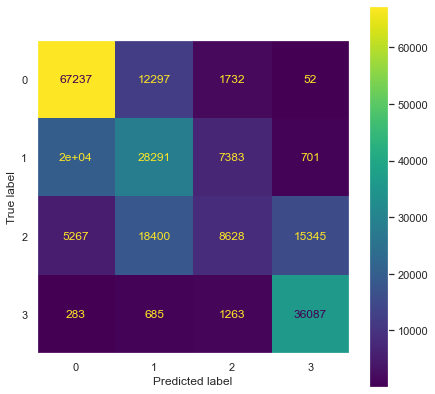

In [136]:
display_model_metrics(X_test, y_test, y_pred_logreg, y_pred_proba_logreg, logreg_model)

### Logistics Regression Model - Parameter Tuning

In [264]:
base_log_reg = LogisticRegression(multi_class='multinomial',
                                      random_state = 888, 
                                      class_weight= y_installs_weights['weights'])

In [265]:
param_log_reg_dict = {
    'solver' : ['newton-cg','sag','saga'],
    'C' : np.logspace(0, 4, 10)
}

In [266]:
grid_log_reg_model = GridSearchCV(estimator= base_log_reg, param_grid = param_log_reg_dict , cv=5 , verbose= 1)
grid_log_reg_model

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 1.0, 1: 1.44,
                                                        2: 1.71, 3: 2.12},
                                          multi_class='multinomial',
                                          random_state=888),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'solver': ['newton-cg', 'sag', 'saga']},
             verbose=1)

In [267]:
grid_log_reg_model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which me

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which mean

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={0: 1.0, 1: 1.44,
                                                        2: 1.71, 3: 2.12},
                                          multi_class='multinomial',
                                          random_state=888),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'solver': ['newton-cg', 'sag', 'saga']},
             verbose=1)

In [268]:
grid_log_reg_model.best_params_

{'C': 166.81005372000593, 'solver': 'newton-cg'}

In [277]:
logreg_model_tuned = LogisticRegression(multi_class='multinomial', solver='newton-cg', C = 166.81005372000593,
                           random_state=13, class_weight= y_installs_weights['weights'])
logreg_model_tuned.fit(X_train,y_train)

LogisticRegression(C=166.81005372000593,
                   class_weight={0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12},
                   multi_class='multinomial', random_state=13,
                   solver='newton-cg')

In [278]:
y_pred_logreg_tuned = logreg_model_tuned.predict(X_test)
y_pred_logreg_tuned

array([2, 3, 3, ..., 1, 1, 2])

In [279]:
y_pred_logreg_proba_tuned = logreg_model_tuned.predict_proba(X_test)
y_pred_logreg_proba_tuned

array([[1.97866579e-04, 4.11732548e-02, 5.65513172e-01, 3.93115706e-01],
       [1.85937685e-04, 1.72479990e-02, 2.77497416e-01, 7.05068648e-01],
       [2.90808797e-05, 7.97798716e-03, 2.35487264e-01, 7.56505668e-01],
       ...,
       [6.49718849e-02, 5.38175872e-01, 3.87394696e-01, 9.45754792e-03],
       [5.45521316e-02, 5.06864265e-01, 4.28629419e-01, 9.95418469e-03],
       [1.13824557e-04, 3.08891039e-02, 5.34981702e-01, 4.34015370e-01]])

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     81318
           1       0.47      0.50      0.49     56352
           2       0.45      0.18      0.26     47640
           3       0.69      0.94      0.80     38318

    accuracy                           0.63    223628
   macro avg       0.59      0.61      0.58    223628
weighted avg       0.60      0.63      0.60    223628

Log Loss: 0.8335103238896695
ROC AUC (One-vs-rest): 0.8484582956409675
ROC AUC (One-vs-one): 0.846848440375448


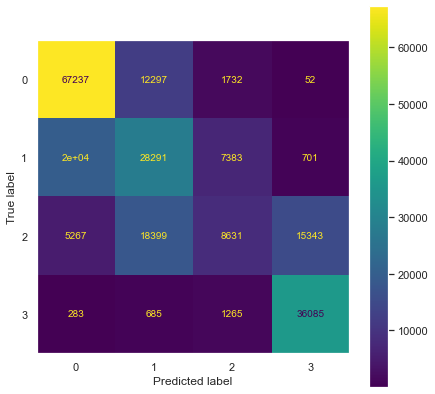

In [280]:
display_model_metrics(X_test, y_test, y_pred_logreg_tuned, y_pred_logreg_proba_tuned, logreg_model_tuned)

### KNN model

In [175]:
knn_model = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'distance') 
knn_model.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [176]:
y_pred_knn = knn_model.predict(X_test)
y_pred_knn

array([2, 3, 3, ..., 2, 2, 2])

In [177]:
y_pred_proba_knn = knn_model.predict_proba(X_test)
y_pred_proba_knn

array([[0.        , 0.14980123, 0.626785  , 0.22341378],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.46158672, 0.53841328],
       ...,
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.41862061, 0.58137939, 0.        ],
       [0.        , 0.        , 0.64091481, 0.35908519]])

### KNN Model evaluation - confusion matrix, AUC, LogLoss

              precision    recall  f1-score   support

           0       0.73      0.80      0.76     81318
           1       0.49      0.46      0.47     56352
           2       0.47      0.41      0.44     47640
           3       0.73      0.79      0.76     38318

    accuracy                           0.63    223628
   macro avg       0.61      0.61      0.61    223628
weighted avg       0.62      0.63      0.62    223628

Log Loss: 4.175221822298222
ROC AUC (One-vs-rest): 0.8300845348920007
ROC AUC (One-vs-one): 0.8277134651340008


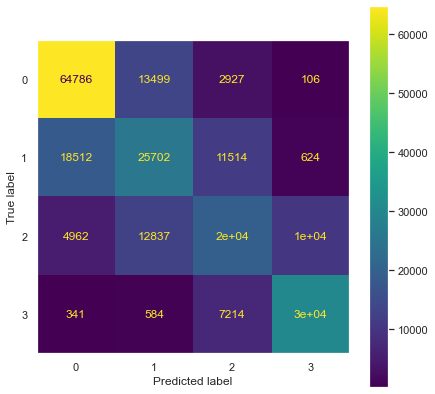

In [178]:
display_model_metrics(X_test, y_test, y_pred_knn, y_pred_proba_knn, knn_model)

### KNN Model - Parameter Tuning

### Decision Tree Model

In [171]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, class_weight=y_installs_weights['weights'])
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12},
                       criterion='entropy', max_depth=5)

In [172]:
y_pred_dt = dt_model.predict(X_test)
y_pred_dt

array([2, 3, 3, ..., 2, 1, 2])

In [173]:
y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_dt

array([[0.00461152, 0.0686194 , 0.50092952, 0.42583956],
       [0.        , 0.0011125 , 0.15743568, 0.84145182],
       [0.        , 0.0011125 , 0.15743568, 0.84145182],
       ...,
       [0.04602546, 0.44418084, 0.49404734, 0.01574637],
       [0.15926585, 0.5279034 , 0.30666208, 0.00616866],
       [0.00461152, 0.0686194 , 0.50092952, 0.42583956]])

### Decision Tree Model evaluation - confusion matrix, AUC, LogLoss

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     81318
           1       0.45      0.44      0.44     56352
           2       0.50      0.38      0.43     47640
           3       0.71      0.92      0.80     38318

    accuracy                           0.62    223628
   macro avg       0.60      0.62      0.61    223628
weighted avg       0.61      0.62      0.61    223628

Log Loss: 0.8070426432926076
ROC AUC (One-vs-rest): 0.8515937300087892
ROC AUC (One-vs-one): 0.8497670028619471


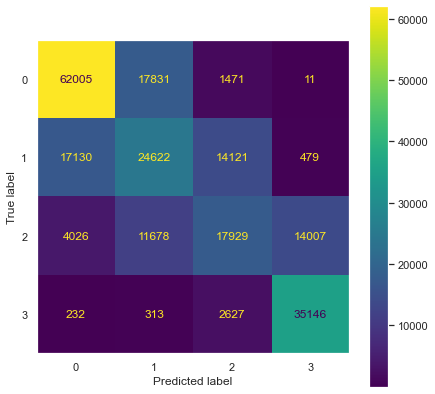

In [174]:
display_model_metrics(X_test, y_test, y_pred_dt, y_pred_proba_dt, dt_model)

### Random Forest Model

In [157]:
rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 555, 
                                       class_weight= 'balanced') 

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=555)

In [158]:
y_pred_rf = rf_model.predict(X_test)
y_pred_rf

array([2, 3, 3, ..., 2, 2, 3])

In [159]:
y_pred_proba_rf = rf_model.predict_proba(X_test)
y_pred_proba_rf

array([[0.01      , 0.1       , 0.51      , 0.38      ],
       [0.        , 0.02      , 0.12546795, 0.85453205],
       [0.        , 0.        , 0.36      , 0.64      ],
       ...,
       [0.01      , 0.12      , 0.87      , 0.        ],
       [0.        , 0.42      , 0.58      , 0.        ],
       [0.        , 0.04      , 0.31      , 0.65      ]])

### Random Forest Regression Model evaluation - confusion matrix, ROC AUC, LogLoss

              precision    recall  f1-score   support

           0       0.75      0.82      0.79     81318
           1       0.52      0.49      0.50     56352
           2       0.53      0.40      0.46     47640
           3       0.74      0.86      0.80     38318

    accuracy                           0.66    223628
   macro avg       0.63      0.64      0.64    223628
weighted avg       0.64      0.66      0.65    223628

Log Loss: 0.9568304616694282
ROC AUC (One-vs-rest): 0.872270491959703
ROC AUC (One-vs-one): 0.8692123180769612


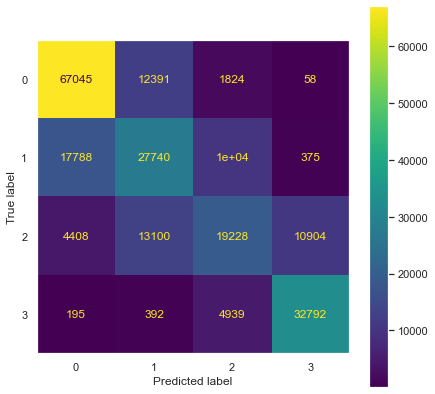

In [160]:
display_model_metrics(X_test, y_test, y_pred_rf, y_pred_proba_rf, rf_model)

### Random Forest Model - Parameter Tuning

In [424]:
base_rf = RandomForestClassifier(random_state = 888)

In [425]:
param_dict_rf = { 
    'class_weight' : ['balanced', y_installs_weights['weights']],
    #'max_depth' : [2,3,4,5] , 
    'criterion': ['gini','entropy'],
    'n_estimators': [10, 50 , 100]}
param_dict_rf

{'class_weight': ['balanced', {0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12}],
 'criterion': ['gini', 'entropy'],
 'n_estimators': [10, 50, 100]}

In [426]:
grid_rf_model = GridSearchCV(estimator= base_rf, param_grid = param_dict_rf , cv=5 , verbose= 1)
grid_rf_model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=888),
             param_grid={'class_weight': ['balanced',
                                          {0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12}],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 50, 100]},
             verbose=1)

In [427]:
grid_rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 56.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=888),
             param_grid={'class_weight': ['balanced',
                                          {0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12}],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 50, 100]},
             verbose=1)

In [428]:
rf_grid_model.best_params_

{'class_weight': {0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12},
 'criterion': 'entropy',
 'n_estimators': 100}

In [434]:
rf_grid_model_tuned = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', 
                                              random_state = 555, class_weight = y_installs_weights['weights'])
rf_grid_model_tuned.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 1.44, 2: 1.71, 3: 2.12},
                       criterion='entropy', random_state=555)

In [435]:
y_pred_rf_tuned = rf_grid_model_tuned.predict(X_test)
y_pred_rf_tuned

array([2, 3, 3, ..., 2, 2, 3])

In [436]:
y_pred_proba_rf_tuned = rf_grid_model_tuned.predict_proba(X_test)
y_pred_proba_rf_tuned

array([[0.02      , 0.16      , 0.42      , 0.4       ],
       [0.        , 0.01      , 0.23707586, 0.75292414],
       [0.        , 0.        , 0.38      , 0.62      ],
       ...,
       [0.        , 0.12      , 0.88      , 0.        ],
       [0.        , 0.40627451, 0.59372549, 0.        ],
       [0.        , 0.04      , 0.46      , 0.5       ]])

              precision    recall  f1-score   support

           0       0.75      0.82      0.79     81318
           1       0.52      0.49      0.50     56352
           2       0.53      0.41      0.46     47640
           3       0.74      0.85      0.79     38318

    accuracy                           0.66    223628
   macro avg       0.63      0.64      0.64    223628
weighted avg       0.64      0.66      0.65    223628

Log Loss: 0.9511829903524132
ROC AUC (One-vs-rest): 0.8724037899903927
ROC AUC (One-vs-one): 0.8693661955817173


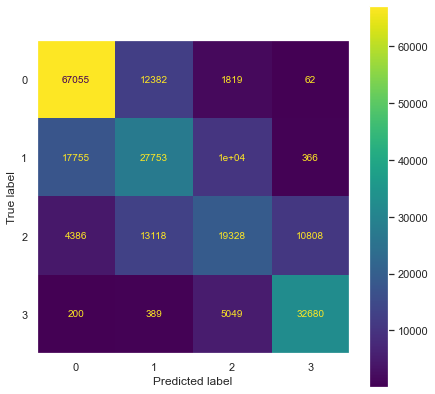

In [437]:
display_model_metrics(X_test, y_test, y_pred_rf_tuned, y_pred_proba_rf_tuned, rf_grid_model_tuned)

### Gradient Boosting Model

In [163]:
model_gb = GradientBoostingClassifier(n_estimators= 100 , learning_rate= 0.1 , max_depth= 10, 
                                      random_state=12)
model_gb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, random_state=12)

In [164]:
y_pred_gb = model_gb.predict(X_test)
y_pred_gb

array([2, 3, 3, ..., 2, 1, 3])

In [165]:
y_pred_proba_gb = model_gb.predict_proba(X_test)
y_pred_proba_gb

array([[1.62470284e-03, 6.36660650e-02, 6.08402414e-01, 3.26306819e-01],
       [4.33865452e-04, 7.00673058e-03, 2.43497010e-01, 7.49062394e-01],
       [2.12432948e-04, 1.46851741e-03, 1.37493353e-01, 8.60825696e-01],
       ...,
       [3.90385592e-02, 4.13354662e-01, 5.40440739e-01, 7.16604018e-03],
       [9.77431961e-02, 4.48571259e-01, 4.48348926e-01, 5.33661822e-03],
       [4.61299294e-03, 5.64533074e-02, 4.65462432e-01, 4.73471267e-01]])

### Gradient Boosting Model evaluation - confusion matrix, ROC AUC, LogLoss

              precision    recall  f1-score   support

           0       0.73      0.88      0.80     81318
           1       0.53      0.45      0.49     56352
           2       0.56      0.38      0.45     47640
           3       0.73      0.88      0.80     38318

    accuracy                           0.66    223628
   macro avg       0.64      0.65      0.63    223628
weighted avg       0.64      0.66      0.65    223628

Log Loss: 0.7304396355263932
ROC AUC (One-vs-rest): 0.8790639129872735
ROC AUC (One-vs-one): 0.8744384394053335


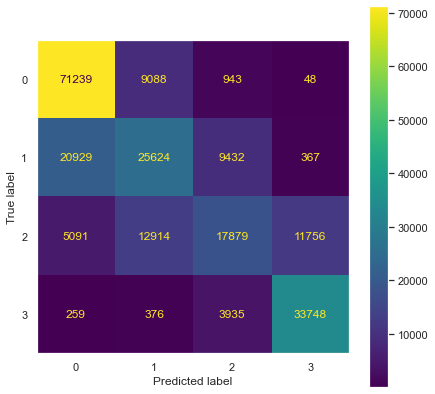

In [166]:
display_model_metrics(X_test, y_test, y_pred_gb, y_pred_proba_gb, model_gb)

### XGBoost Model

In [167]:
model_xgboost = xgb.XGBClassifier(objective='multi:softmax', random_state =42, max_depth=6, gamma=1.0, learning_rate=0.1)

model_xgboost.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='mlogloss', 
                  eval_set=[(X_test, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
y_pred_xgb = model_xgboost.predict(X_test)
y_pred_xgb

array([2, 3, 3, ..., 2, 1, 2])

In [169]:
y_pred_proba_xgb = model_xgboost.predict_proba(X_test)
y_pred_proba_xgb

array([[0.00149394, 0.09347808, 0.5598136 , 0.34521437],
       [0.00111688, 0.00747989, 0.23994705, 0.75145614],
       [0.00083012, 0.00214555, 0.17279837, 0.824226  ],
       ...,
       [0.046449  , 0.4454913 , 0.49899745, 0.00906224],
       [0.1930299 , 0.4701325 , 0.33007693, 0.00676069],
       [0.00337415, 0.0924867 , 0.51443267, 0.38970646]], dtype=float32)

### XGBoost Model evaluation - confusion matrix, ROC AUC, LogLoss

              precision    recall  f1-score   support

           0       0.72      0.88      0.79     81318
           1       0.52      0.45      0.48     56352
           2       0.55      0.33      0.41     47640
           3       0.72      0.90      0.80     38318

    accuracy                           0.66    223628
   macro avg       0.63      0.64      0.62    223628
weighted avg       0.63      0.66      0.63    223628

Log Loss: 0.7473295079577451
ROC AUC (One-vs-rest): 0.872631536818316
ROC AUC (One-vs-one): 0.8675747530874799


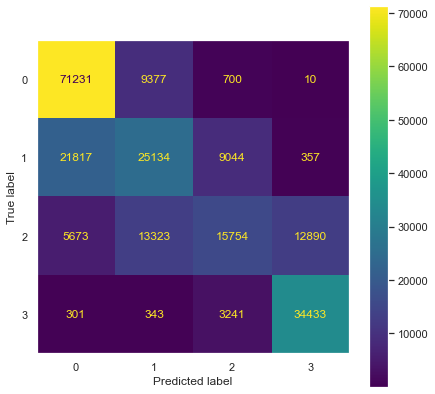

In [170]:
display_model_metrics(X_test, y_test, y_pred_xgb, y_pred_proba_xgb, model_xgboost)

### Dimensionality Reduction - LDA

In [199]:
lda = LDA(n_components = 2)

X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.fit_transform(X_test, y_test)

In [200]:
X_train_lda.shape

(894508, 2)

<font color="blue"> The features have been reduced to 2 only. </font>

In [201]:
lda.explained_variance_ratio_

array([0.91677987, 0.08215892])

<font color="blue"> The first component explains 92% of variance, the second component 0.8% </font>

### Apply LDA on XGBoost Model

In [187]:
xgboost_lda_model = xgb.XGBClassifier(objective='multi:softmax', random_state =42, max_depth=6, gamma=1.0, learning_rate=0.1)

xgboost_lda_model.fit(X_train_lda, y_train, early_stopping_rounds=10, eval_metric='mlogloss', 
                  eval_set=[(X_test_lda, y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [188]:
y_pred_xgb_lda = xgboost_lda_model.predict(X_test_lda)
y_pred_xgb_lda

array([2, 3, 3, ..., 1, 1, 2])

In [189]:
y_pred_proba_xgb_lda = xgboost_lda_model.predict_proba(X_test_lda)
y_pred_proba_xgb_lda

array([[0.00620156, 0.10717875, 0.57552654, 0.31109318],
       [0.00133958, 0.01330148, 0.3698542 , 0.61550474],
       [0.00107005, 0.00390414, 0.23863022, 0.7563956 ],
       ...,
       [0.17970863, 0.5348225 , 0.280718  , 0.00475086],
       [0.19867073, 0.49980772, 0.2954054 , 0.00611614],
       [0.00550449, 0.07630175, 0.54436916, 0.3738246 ]], dtype=float32)

### XGBoost Model + LDA evaluation - confusion matrix, ROC AUC, LogLoss

              precision    recall  f1-score   support

           0       0.71      0.88      0.78     81318
           1       0.50      0.44      0.47     56352
           2       0.52      0.28      0.37     47640
           3       0.71      0.89      0.79     38318

    accuracy                           0.64    223628
   macro avg       0.61      0.62      0.60    223628
weighted avg       0.62      0.64      0.62    223628

Log Loss: 0.785696925121786
ROC AUC (One-vs-rest): 0.8587081128037795
ROC AUC (One-vs-one): 0.8535465677715015


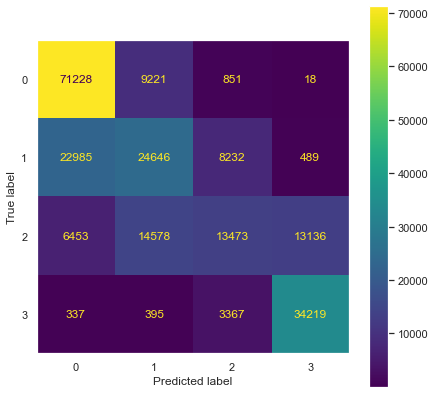

In [191]:
display_model_metrics(X_test_lda, y_test, y_pred_xgb_lda, y_pred_proba_xgb_lda, xgboost_lda_model)

### Feature Importance

<font color="green"> Feature Importance using xgboost plot_importance </font>

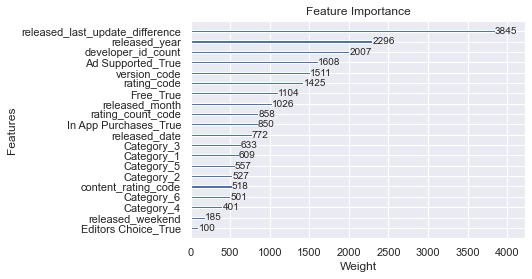

In [250]:
ax = plot_importance(model_xgboost)
ax.set(xlabel='Weight', ylabel='Features', title="Feature Importance")
plt.show()

<font color="green"> Feature Importance using random forest feature_importances </font>

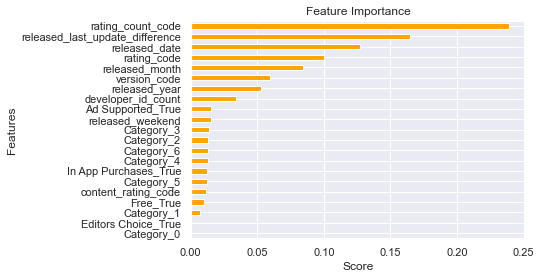

In [248]:
sorted_rf_fi = rf_feature_importance_series.sort_values(axis=0, ascending=True, 
                   inplace=False)
ax = sorted_rf_fi.plot(kind='barh', color='orange')
ax.set(xlabel='Score', ylabel='Features', title="Feature Importance")
plt.show()

In [281]:
# Define a utility function to plot the data (scatterplot)
def tsne_plot(x, y):
      
    # Setting the plotting background
    sns.set(style ="whitegrid")
      
    tsne = TSNE(n_components = 2, random_state = 0)
      
    # Reducing the dimensionality of the data
    X_transformed = tsne.fit_transform(x)
  
    plt.figure(figsize =(12, 8))
      
    # Building the scatter plot
    plt.scatter(X_transformed[np.where(y == 0), 0], 
                X_transformed[np.where(y == 0), 1],
                marker ='o', color ='y', linewidth ='1',
                alpha = 0.8, label ='Normal')
    plt.scatter(X_transformed[np.where(y == 1), 0],
                X_transformed[np.where(y == 1), 1],
                marker ='o', color ='k', linewidth ='1',
                alpha = 0.8, label ='Fraud')
  
    # Specifying the location of the legend
    plt.legend(loc ='best')
      
    # Plotting the reduced data
    plt.show()

In [ ]:
tsne_plot(X, y)

In [461]:
# Building the Input Layer
input_layer = Input(shape =(X.shape[1], ))
  
# Building the Encoder network
encoded = Dense(100, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation ='relu')(encoded)
  
# Building the Decoder network
decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(100, activation ='tanh')(decoded)
  
# Building the Output Layer
output_layer = Dense(X.shape[1], activation ='relu')(decoded)

In [463]:
# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="mse")
  
# Training the Auto-encoder network
autoencoder.fit(X, X, 
                batch_size = 16, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10
55907/55907 [==============================] - 53s 936us/step - loss: 0.5303 - val_loss: 0.2196
Epoch 2/10
55907/55907 [==============================] - 59s 1ms/step - loss: 0.2152 - val_loss: 0.1726
Epoch 3/10
55907/55907 [==============================] - 57s 1ms/step - loss: 0.1799 - val_loss: 0.1639
Epoch 4/10
55907/55907 [==============================] - 51s 920us/step - loss: 0.1719 - val_loss: 0.1563
Epoch 5/10
55907/55907 [==============================] - 49s 876us/step - loss: 0.1627 - val_loss: 0.1435
Epoch 6/10
55907/55907 [==============================] - 51s 907us/step - loss: 0.1518 - val_loss: 0.1395
Epoch 7/10
55907/55907 [==============================] - 49s 872us/step - loss: 0.1486 - val_loss: 0.1369
Epoch 8/10
55907/55907 [==============================] - 52s 923us/step - loss: 0.1462 - val_loss: 0.1346
Epoch 9/10
55907/55907 [==============================] - 74s 1ms/step - loss: 0.1437 - val_loss: 0.1318
Epoch 10/10
55907/55907 [==================

In [464]:
# Retaining the encoder part of the Auto-encoder to encode data
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

In [462]:
# Splitting the encoded data for linear classification
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2, random_state=13, stratify=encoded_y)

NameError: name 'encoded_X' is not defined

In [ ]:
# Building the logistic regression model
lrclf = LogisticRegression()
lrclf.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the linear model
y_pred_lrclf = lrclf.predict(X_test_encoded)
  
# Evaluating the performance of the linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred_lrclf)))